# Sentiment Analysis in Czech
### Capstone Project for Machine Learning Nanodegree at Udacity

- [Part 1: Loading the data and extracting samples](#Part-1:-Load-our-datasets-and-extract-one-sentence-samples)
- [Part 2: Data preprocessing](#Part-2:-Preprocess-our-datasets)
- [Part 3: Defining the neural network and benchmark](#Part-3:-Define-our-neural-network-and-benchmark-models)
- [Part 4: Creating the individual models](#Part-4:-Create-the-individual-models-and-train)
    - [Facebook Model](#Facebook-Model)
    - [ČSFD Model](#ČSFD-Model)
    - [MALL.CZ Model](#MALL.CZ-Model)
    - [Combined Model](#Combined-Model)
- [Part 5: Running tests with new sentences](#Part-5:-Running-tests-with-new-sentences)

#### ⏱ NOTE:
Some cells in Part 1 and 2 contain time-consuming tasks like data transformations. If you run the whole notebook at least once, their outputs will already be saved in this project subdirectories and you don't have to run them again in the future. These cells are marked with a stopwatch emoji ⏱ in the titles above them.

---

In [1]:
%%capture
import pandas as pd
import numpy as np
import subprocess
import string
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.util import SAD, HAPPY
from lib.czech_stemmer import cz_stem

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#### Having problem with NLTK tokenizer? 
You might need to run `nltk.download()` and download `Punkt Tokenizer Models`. More information in [this SO thread](https://stackoverflow.com/a/10852888).

---

## Part 1: Load our datasets and extract one-sentence samples

In [2]:
labels = {'n':'NEG', '0':'NEU', 'p':'POS', 'b':'BIP'}
target_labels = [labels['n'], labels['0'], labels['p']]
max_sentence_length = 30 # no. of words

def data_stats(data, dataset='Dataset', do_print=False):
    '''
    Returns basic statistics about a dataset.
    
    If the third argument is set to True, the function will
    print out the stats instead.
    '''
    num_of_neg = len(data[data['Sentiment'] == labels['n']])
    num_of_neu = len(data[data['Sentiment'] == labels['0']])
    num_of_pos = len(data[data['Sentiment'] == labels['p']])
    num_of_chars = np.mean( data['Post'].apply(lambda post: len(post)) )
    
    if do_print is True:
        print(dataset)
        print('{} positive, {} neutral and {} negative posts.'.format(num_of_pos, num_of_neu, num_of_neg))
        print('Posts are on average {0:3.0f} characters long.'.format(num_of_chars))
        print('='*65 + '\n')
        return None
    
    return (num_of_neg, num_of_neu, num_of_pos)



def load_gold_data(directory, filter_out):
    '''
    Loads a dataset with separate contents and labels. Maps labels to our format.
    Filters out any samples that have a label equal to the second argument.
    
    Returns a new DataFrame.
    '''
    return pd\
        .concat([
            pd.read_csv('data/{}/gold-posts.txt'.format(directory), sep='\n', header=None, names=['Post']),
            pd.read_csv('data/{}/gold-labels.txt'.format(directory), sep=' ', header=None, names=['Sentiment']).iloc[:,0].map(labels)
        ], axis=1)\
        .query('Sentiment != @filter_out')\
        .reset_index(drop=True)

        

def load_data(directory):
    '''
    Loads a dataset whose samples are split to individual files/per class.
    
    Returns a new DataFrame.
    '''
    return pd\
        .concat([
            pd.read_csv('data/{}/positive.txt'.format(directory), sep='\n', header=None, names=['Post']).assign(Sentiment=labels['p']),
            pd.read_csv('data/{}/neutral.txt'.format(directory),  sep='\n', header=None, names=['Post']).assign(Sentiment=labels['0']),
            pd.read_csv('data/{}/negative.txt'.format(directory), sep='\n', header=None, names=['Post']).assign(Sentiment=labels['n'])
        ], axis=0)\
        .reset_index(drop=True)
    

### ⏱ Load the raw datasets

In [3]:
# Load the Facebook CZ comments, map labels to nicer values and remove posts with bipolar sentiment.
facebook_data_raw = load_gold_data('facebook', labels['b'])
data_stats(facebook_data_raw, 'Facebook CZ', True)


# Load the film reviews from ČSFD.
csfd_data_raw = load_data('csfd')
data_stats(csfd_data_raw, 'ČSFD', True)


# Load the product reviews from MALL.
mall_data_raw = load_data('mallcz')
data_stats(mall_data_raw, 'MALL CZ', True)

Facebook CZ
2587 positive, 5174 neutral and 1991 negative posts.
Posts are on average  60 characters long.

ČSFD
30852 positive, 30753 neutral and 29699 negative posts.
Posts are on average 311 characters long.

MALL CZ
102976 positive, 31943 neutral and 10387 negative posts.
Posts are on average 122 characters long.



### ⏱ Extract one-sentence posts subsets for each of the corpora

In [4]:
def filter_one_sentence(data, max_sentence_length):
    '''
    Takes a dataset and filters out any post that is longer than one sentence.
    Also filter out any sentences that are longer than `max_sentence_length`
    
    Returns a tuple (filtered DataFrame, original sentence counts Series).
    '''
    data_sentence_counts = data['Post'].apply( lambda post: len(sent_tokenize(post)) )
    data_indices_multisentence = data_sentence_counts[data_sentence_counts > 1].index.values
    data_onesentence = data.drop(data_indices_multisentence)
    data_word_counts = data_onesentence['Post'].apply( lambda sen: len(word_tokenize(sen)) )
    data_indices_longsentense = data_word_counts[data_word_counts > max_sentence_length].index.values
    
    return (data_onesentence.drop(data_indices_longsentense), data_sentence_counts)

# Filter out any multi-sentence posts for Facebook CZ dataset
facebook_data_onesentence, fb_s_counts = filter_one_sentence(facebook_data_raw, max_sentence_length)
data_stats(facebook_data_onesentence, 'ONE SENTENCE: Facebook CZ', True)

# Filter out any multi-sentence posts for ČSFD dataset
csfd_data_onesentence, csfd_s_counts = filter_one_sentence(csfd_data_raw, max_sentence_length)
data_stats(csfd_data_onesentence, 'ONE SENTENCE: ČSFD', True)

# Filter out any multi-sentence posts for MALL CZ dataset
mall_data_onesentence, mall_s_counts = filter_one_sentence(mall_data_raw, max_sentence_length)
data_stats(mall_data_onesentence, 'ONE SENTENCE: MALL CZ', True)

ONE SENTENCE: Facebook CZ
1968 positive, 3605 neutral and 1296 negative posts.
Posts are on average  53 characters long.

ONE SENTENCE: ČSFD
5039 positive, 6037 neutral and 8464 negative posts.
Posts are on average  71 characters long.

ONE SENTENCE: MALL CZ
56712 positive, 13959 neutral and 3682 negative posts.
Posts are on average  53 characters long.



### ⏱ Plot the sentence counts in our raw data

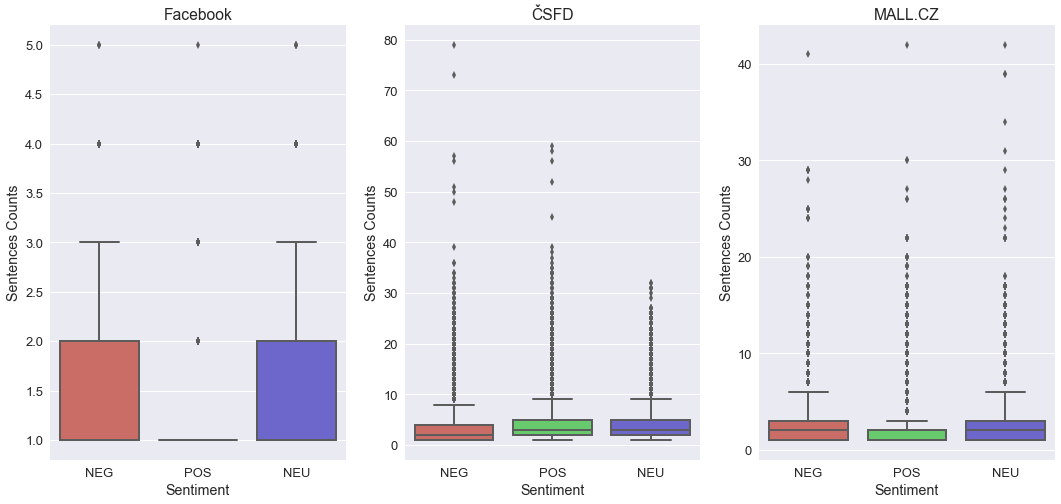

In [5]:
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2})

fig = plt.figure(figsize=(18,8), dpi=72)
subplots = []

datasets_to_plot = [
    (facebook_data_raw, fb_s_counts, 'Facebook'),
    (csfd_data_raw, csfd_s_counts, 'ČSFD'),
    (mall_data_raw, mall_s_counts, 'MALL.CZ'),
]

for i, dataset in enumerate(datasets_to_plot):
    subplots.append(fig.add_subplot(1, 3, i+1))
    sns.boxplot(x='Sentiment', y=dataset[1], 
                data=dataset[0], 
                palette='hls', order=['NEG', 'POS', 'NEU'],
                ax=subplots[i])
    subplots[i].set(title=dataset[2], xlabel='Sentiment', ylabel='Sentences Counts')

plt.show()

### ⏱ Plot one-sentence vs multi-sentence occurences

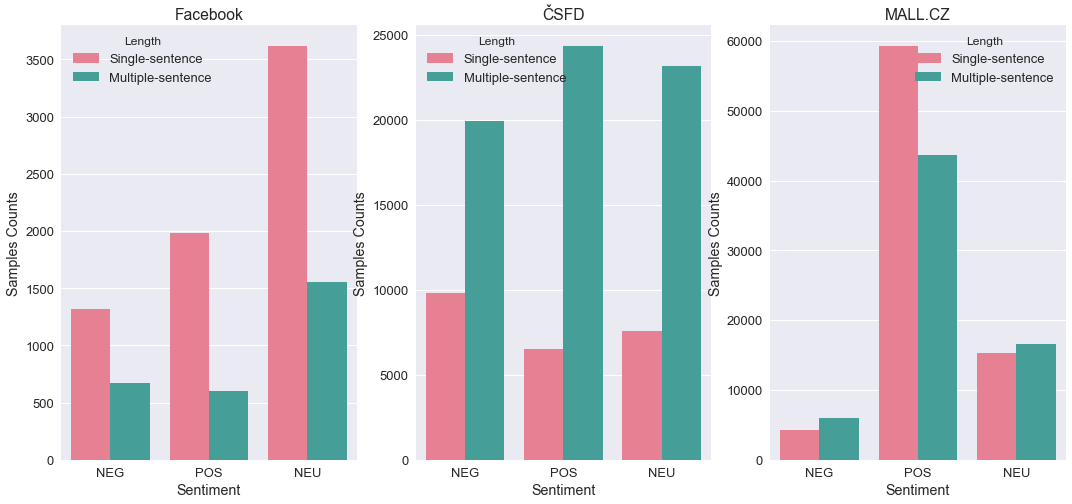

In [6]:
facebook_data_raw['Length'] =   fb_s_counts.apply(lambda c: 'Multiple-sentence' if c > 1 else 'Single-sentence')
csfd_data_raw['Length']     = csfd_s_counts.apply(lambda c: 'Multiple-sentence' if c > 1 else 'Single-sentence')
mall_data_raw['Length']     = mall_s_counts.apply(lambda c: 'Multiple-sentence' if c > 1 else 'Single-sentence')

fig = plt.figure(figsize=(18,8), dpi=72)
subplots = []

datasets_to_plot = [
    (facebook_data_raw, 'Facebook'),
    (csfd_data_raw, 'ČSFD'),
    (mall_data_raw, 'MALL.CZ'),
]

for i, dataset in enumerate(datasets_to_plot):
    subplots.append(fig.add_subplot(1, 3, i+1))
    sns.countplot(x='Sentiment', hue='Length', data=dataset[0], 
                hue_order=['Single-sentence', 'Multiple-sentence'],
                order=['NEG', 'POS', 'NEU'], palette='husl',
                ax=subplots[i])
    subplots[i].set(title=dataset[1], xlabel='Sentiment', ylabel='Samples Counts')

plt.show()

### ⏱ Combine the three datasets to our final training data

In [7]:
# Close your eyes, this is messy and I was lazy to refactor it...

def create_joint_dataset(datasets):
    '''
    Takes multiple datasets (from smallest to largest), computes which class
    has the least samples and creates a joint dataset so that all classes
    are represented equally (strips off excessive samples).
    
    Returns a new joint DataFrame.
    '''
    
    data_size_limit = min(
        [ sum(x) for x in zip( *[data_stats(dataset) for dataset in datasets] ) ]
    )

    aggregate_size = [0, 0, 0]
    results = [None, None, None]
    
    for i,dataset in enumerate(datasets):
        neg, neu, pos = data_stats(dataset)
        new_would = [
            aggregate_size[0]+neg,
            aggregate_size[1]+neu,
            aggregate_size[2]+pos
        ]
        
        if max(new_would) > data_size_limit:
            results[i] = (abs(data_size_limit-new_would[0]),
                          abs(data_size_limit-new_would[1]),
                          abs(data_size_limit-new_would[2]))
        else:
            results[i] = (0, 0, 0)
        
        aggregate_size = new_would    
    
    result_datas = [None, None, None]
    for i,res in enumerate(results):
        result_datas[i] = datasets[i]\
            .drop(datasets[i].query('Sentiment == "POS"').iloc[:res[2]].index.values)\
            .drop(datasets[i].query('Sentiment == "NEU"').iloc[:res[1]].index.values)\
            .drop(datasets[i].query('Sentiment == "NEG"').iloc[:res[0]].index.values)

    
    return pd\
        .concat([
            result_datas[0],
            result_datas[1],
            result_datas[2]
        ], axis=0)\
        .reset_index(drop=True)

In [8]:
# ⏱ Combine the one-sentence datasets into one joint set
combined_data_onesentence = create_joint_dataset([facebook_data_onesentence, csfd_data_onesentence, mall_data_onesentence])
data_stats(combined_data_onesentence, 'FINAL ONE SENTENCE: Combined set', True)

FINAL ONE SENTENCE: Combined set
13442 positive, 13442 neutral and 13442 negative posts.
Posts are on average  64 characters long.



---

## Part 2: Preprocess our datasets

### Define the sentence processor

In [9]:
def create_processor(aggressive = False):
    '''
    Creates a processor instance with set stemmer aggressivity.
    Default stemmer aggressivity is False, which means 'light' stemming.
    
    Returns a sentence processor function.
    '''
    
    punctuation_mapping = str.maketrans(
        dict.fromkeys(string.punctuation+'0123456789²½¾ˇ', ' ')
    )
    
    happy_emojis_regex  = "|".join( map(re.escape, HAPPY) )
    sad_emojis_regex    = "|".join( map(re.escape, SAD) )

    def sent_processor(sentence):
        '''
        Takes a sentence, replaces emojis with keywords, strips off punctuation,
        numbers and excessive whitespace and converts the sentence to lower case.
        The sentence is also capped at `max_sentence_length` words.
        
        Returns a list of processed words.
        '''
        def split_sentence(sentence):
            split_sentence = re.sub('\s+', ' ', sentence).split(' ')
            return [] if len(sentence) == 0 else split_sentence

        def remove_punc(sentence):
            return \
                re.sub(sad_emojis_regex, ' sadmoji ',
                    re.sub(happy_emojis_regex, ' happymoji ', sentence)
                )\
                .translate(punctuation_mapping)\
                .lower()\
                .strip()

        def stem(sentence, aggressive):
            stemmed = [
                cz_stem(word, aggressive) 
                for word in split_sentence(sentence)
            ][:max_sentence_length]
        
            return ['prázdno'] if len(stemmed) < 1 else stemmed

        return stem(remove_punc(sentence), aggressive)
    
    return sent_processor

In [10]:
# Create a processor instance
sent_processor = create_processor()

### ⏱ Create a joint dataset for word vectors learning

Combine all of our three *raw* corpora, run the posts through the sentence processor and save the processed text in a `.txt` file which will serve for the word vectors training.

In [11]:
%%capture

combined_data_processed = pd\
    .concat([
        facebook_data_raw,
        csfd_data_raw,
        mall_data_raw
    ], axis=0)\
    ['Post']\
    .apply(lambda post: ' '.join( sent_processor(post) ))

combined_data_processed.to_csv('data/combined_corpora_processed.txt', 
                               encoding='utf-8', index=False)

# Delete the combined dataframe to free up the memory, we won't need it in our code anymore
del combined_data_processed

---

### Train word vectors

Now you can go and run **`train_word_vectors.sh`** file from your console. 

After you're finished with training and **`combined_corpora_processed.bin`** model is created in `word_models` directory, you can continue to the next cell.

#### Getting fastText library

You will need a working **`fasttext`** binary in order to train or use word vectors. A binary for macOS is already provided in `lib` directory. If you're on Mac, this should work out of box and you can go run the `train_word_vectors.sh` Shell script.

If it doesn't work for you or you're not on Mac, you can obtain your binary via *quickly* building the fastText source. It's literally 3 commands.

[More info on getting the `fasttext` binary here](https://fasttext.cc/docs/en/support.html)

Once you have your binary, put it inside the project's **`lib`** directory. The following Python script will call a subprocess with the path explicitly defined as `lib/fasttext`.

---

### Load the word represenation model

In [12]:
def load_word_model(model = 'word_models/combined_corpora_processed.bin'):
    '''
    Loads a fastText word representation model.
    NOTE: Load a word model no more than once per kernel!
    
    Returns a function for getting word vectors.
    '''
    
    word_model = subprocess.Popen(
        ['lib/fasttext', 'print-word-vectors', model], 
        stdout=subprocess.PIPE, stdin=subprocess.PIPE)
    
    def get_word_vector(word):
        '''
        Takes a single processed word.
        
        Returns a list of word vector representation.
        '''
        
        word_model.stdin.write( bytes('{}\n'.format(word), 'utf-8') )
        word_model.stdin.flush()
        return [
            float(value) for value in \
            word_model.stdout.readline()\
                .decode('utf-8')\
                .replace('{} '.format(word), '')\
                .replace(' \n', '')\
                .split(' ')  
        ]
    
    return get_word_vector

In [13]:
# Load the word embedding model
word_vector = load_word_model()
word_vector_dim = 100

### Define a function for obtaining sentence tensors from text sentence

In [14]:
def sentence_tensor(sentence):
    '''
    Takes a sentence, runs it through the sentence processor
    and obtains word vectors for all of the processed words.
    Pads the array so it matches our input size.
    
    Returns a 2D numpy array containing word vectors.
    '''

    sentence_array = [word_vector(word) for word in sent_processor(sentence)]
    
    return np.pad(sentence_array, 
                  pad_width=( 
                      (0, max_sentence_length - len(sentence_array)), 
                      (0, 0) 
                  ), 
                  mode='constant')

### ⏱ Process the text data and save our final  sets

In [15]:
def dataset_process_save(dataframe, name):
    '''
    Takes a DataFrame, obtains sentence tensors for each
    entry and saves the 3D numpy array as .npy
    
    The labels are one-hot-encoded and also saved as .npy
    '''
    
    y_labels = pd.get_dummies(dataframe, columns=['Sentiment']).drop('Post', axis=1).as_matrix()
    np.save('data/{}_y.npy'.format(name), y_labels)
    print('\'{}_y\' labels successfully saved!'.format(name))
    
    x_data = np.stack([sentence_tensor(post) for post in dataframe['Post']])
    np.save('data/{}_x.npy'.format(name), x_data)
    print('\'{}_x\' sentences successfully saved!\n'.format(name))
    
    del x_data, y_labels
    return None

dataset_process_save(facebook_data_onesentence, 'facebook')
dataset_process_save(csfd_data_onesentence, 'csfd')
dataset_process_save(mall_data_onesentence, 'mall')
dataset_process_save(combined_data_onesentence, 'combined')

# Delete the processed DataFrames to free up the memory, we won't need them in our code anymore
del facebook_data_onesentence, csfd_data_onesentence, mall_data_onesentence, combined_data_onesentence

'facebook_y' labels successfully saved!
'facebook_x' sentences successfully saved!

'csfd_y' labels successfully saved!
'csfd_x' sentences successfully saved!

'mall_y' labels successfully saved!
'mall_x' sentences successfully saved!

'combined_y' labels successfully saved!
'combined_x' sentences successfully saved!



### Define a loader for our final processed datasets from `.npy` files

In [16]:
def load_xy(dataset = 'small_data'):
    '''
    Loads X and Y for specified dataset. Shuffles and splits into 
    training and testing sets.
    
    Returns X_train, X_test, y_train, y_test 
    '''
    X = np.load('data/{}_x.npy'.format(dataset))
    y = np.load('data/{}_y.npy'.format(dataset))
    
    return train_test_split(X, y, test_size=0.1, random_state=29, shuffle=True)

---

## Part 3: Define our neural network and benchmark models

<p>&nbsp;</p>
<p>&nbsp;</p>

![Convolutional Neural Network Architecture Used for the Project](images/cnn.png)

<p>&nbsp;</p>

---

### Define our `CNN` class

In [17]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout, Dense

class CNN():
    def __init__(self, name = 'unnamed', optimizer = 'adagrad'):
        '''
        Creates and compiles a new model. Prints out its summary.
        '''
        
        self.name = name
        self.model_weights = 'models/weights.best.{}.hdf5'.format(self.name)
        
        self.model = Sequential()
        self.model.add(
            Conv1D(filters = 64, kernel_size = 4, 
                   activation = 'relu', padding = 'same',
                   input_shape = (max_sentence_length, word_vector_dim))
        )
        self.model.add(MaxPooling1D(pool_size = 2))
        
        self.model.add(
            Conv1D(filters = 128, kernel_size = 8, 
                   activation = 'relu', padding = 'same',)
        )
        self.model.add(MaxPooling1D(pool_size = 2))
        
        self.model.add(GlobalMaxPooling1D())
        self.model.add(Dense(units = len(target_labels), activation = 'softmax'))
        
        self.model.compile(optimizer = optimizer, 
                           loss = 'categorical_crossentropy', 
                           metrics = ['categorical_accuracy'])

        self.model.summary()
        
        return None
    
    def fit(self, X_train, y_train, epochs = 20, batch_size = 1000, validation_split = 0.15):
        '''
        Trains and cross-validates the model on the provided
        training set `X_train` and `y_train`. You can also setup
        `epochs`, `batch_size` and `validation_split`.
        
        Returns self.
        '''
        
        print('\nFitting \'{}\' model...\n'.format(self.name) + '_'*65)
        self.checkpointer = ModelCheckpoint(filepath = self.model_weights, 
                                            verbose = 1, save_best_only = True)
        
        self.model.fit(X_train, y_train, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = validation_split, 
                       callbacks = [self.checkpointer], 
                       verbose = 1)
        
        self.load()
        
        return self
    
    def load(self):
        '''
        Loads the saved weights for the model.
        
        Returns self.
        '''
        
        self.model.load_weights(self.model_weights)
        print('_'*65 + '\nLoaded the weights for \'{}\' model.\n'.format(self.name))
        
        return self
    
    def predict(self, sentence, proba = False):
        '''
        Takes a `sentence` and predicts its label.
        
        Returns the label index.
        '''
        
        sentence_array = np.expand_dims(sentence_tensor(sentence), axis=0) \
                         if type(sentence) is str else \
                         np.expand_dims(sentence, axis=0)
    
        prediction = self.model.predict(sentence_array)
        return np.argmax(prediction) if proba is False else prediction
    
    def predict_proba(self, sentence):
        '''
        Takes a `sentence` and predicts its label.
        
        Returns a vector containing probabilities of belonging to each of the labels.
        '''
        
        return self.predict(sentence, True)
    
    def score(self, X_test, y_test):
        '''
        Computes the accuracy and weighted F1 score for the provided
        testing set `X_test` and `y_test`.
        
        Returns tuple (accuracy, F1, individual F1s).
        '''
        
        predictions = [self.predict(sentence) for sentence in X_test]
        true = np.argmax(y_test, axis=1)
        
        return (
            np.sum(np.array(predictions) == true) / len(predictions),
            f1_score(true, predictions, average = 'weighted'),
            f1_score(true, predictions, average = None)
        )

    
    def test(self, X_test, y_test):
        '''
        Obtains and prints out accuracy and F1 scores for the provided
        testing set `X_test` and `y_test`.
        
        Returns self.
        '''
        
        accuracy_score_, f1_score_, f1_scores_ = self.score(X_test, y_test)

        print('_'*65)
        print('SCORES FOR \'{}\' MODEL'.format(self.name))
        print('Test Accuracy: {0:2.4f}%'.format(accuracy_score_*100))
        print('F1 Score: {0:2.4f}'.format(f1_score_))
        print('F1 Scores: {}'.format(f1_scores_))
        print('='*65 + '\n')
        
        return self
    
    def benchmark(self, X_test, y_test):
        '''
        Obtains and prints out accuracy and F1 scores for the provided
        testing set `X_test` and `y_test`.
        
        Returns self.
        '''
        
        true = np.argmax(y_test, axis=1)
        choices = list( set(true) )

        weights = [
            (true == label).sum() / true.sum()
            for label in choices
        ]
        
        def bench_predict(sentence):
            '''
            Takes a `sentence` and predicts weighted random label.

            Returns the label index.
            '''

            return random.choices(choices, weights)[0]
        
        predictions = [bench_predict(sentence) for sentence in X_test]

        print('_'*65)
        print('SCORES FOR \'{}\' BENCHMARK MODEL'.format(self.name))
        print('Test Accuracy: {0:2.4f}%'.format(np.sum(np.array(predictions) == true) / len(predictions)))
        print('F1 Score: {0:2.4f}'.format(f1_score(true, predictions, average = 'weighted')))
        print('F1 Scores: {}'.format(f1_score(true, predictions, average = None)))
        print('='*65 + '\n')

        return self

Using TensorFlow backend.


---

## Part 4: Create the individual models and train
### Facebook Model

In [30]:
# Load the processed data set
facebook_X_train, facebook_X_test, \
    facebook_y_train, facebook_y_test = load_xy('facebook')

# Initiate the model
facebook_model = CNN('facebook')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 30, 64)            25664     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 15, 128)           65664     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 91,715
Trainable params: 91,715
Non-trainable params: 0
_________________________________________________________________


In [31]:
facebook_model.fit(facebook_X_train, facebook_y_train, epochs=5, batch_size=20)\
              .test(facebook_X_test, facebook_y_test)\
              .benchmark(facebook_X_test, facebook_y_test);


Fitting 'facebook' model...
_________________________________________________________________
Train on 5254 samples, validate on 928 samples
Epoch 1/5
5254/5254 [==============================] - 7s - loss: 0.7154 - categorical_accuracy: 0.6880 - val_loss: 0.6515 - val_categorical_accuracy: 0.7091
Epoch 2/5
5254/5254 [==============================] - 6s - loss: 0.5392 - categorical_accuracy: 0.7758 - val_loss: 0.6102 - val_categorical_accuracy: 0.7435
Epoch 3/5
5254/5254 [==============================] - 7s - loss: 0.4559 - categorical_accuracy: 0.8211 - val_loss: 0.6266 - val_categorical_accuracy: 0.7414
Epoch 4/5
5254/5254 [==============================] - 6s - loss: 0.3837 - categorical_accuracy: 0.8525 - val_loss: 0.6403 - val_categorical_accuracy: 0.7392
Epoch 5/5
5254/5254 [==============================] - 6s - loss: 0.3218 - categorical_accuracy: 0.8805 - val_loss: 0.6405 - val_categorical_accuracy: 0.7500
_________________________________________________________________
Lo

### ČSFD Model

In [32]:
# Load the processed data set
csfd_X_train, csfd_X_test, \
    csfd_y_train, csfd_y_test = load_xy('csfd')

# Initiate the model
csfd_model = CNN('csfd')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 30, 64)            25664     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 15, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 15, 128)           65664     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 91,715
Trainable params: 91,715
Non-trainable params: 0
_________________________________________________________________


In [33]:
csfd_model.fit(csfd_X_train, csfd_y_train, epochs=5, batch_size=20)\
          .test(csfd_X_test, csfd_y_test)\
          .benchmark(csfd_X_test, csfd_y_test);


Fitting 'csfd' model...
_________________________________________________________________
Train on 14948 samples, validate on 2638 samples
Epoch 1/5
14948/14948 [==============================] - 21s - loss: 0.7071 - categorical_accuracy: 0.6846 - val_loss: 0.6533 - val_categorical_accuracy: 0.7187
Epoch 2/5
14948/14948 [==============================] - 20s - loss: 0.6015 - categorical_accuracy: 0.7406 - val_loss: 0.6306 - val_categorical_accuracy: 0.7339
Epoch 3/5
14948/14948 [==============================] - 18s - loss: 0.5526 - categorical_accuracy: 0.7672 - val_loss: 0.6354 - val_categorical_accuracy: 0.7316
Epoch 4/5
14948/14948 [==============================] - 14s - loss: 0.5091 - categorical_accuracy: 0.7893 - val_loss: 0.6283 - val_categorical_accuracy: 0.7358
Epoch 5/5
14948/14948 [==============================] - 16s - loss: 0.4656 - categorical_accuracy: 0.8172 - val_loss: 0.6485 - val_categorical_accuracy: 0.7176
_______________________________________________________

### MALL.CZ Model

In [34]:
# Load the processed data set
mall_X_train, mall_X_test, \
    mall_y_train, mall_y_test = load_xy('mall')

# Initiate the model
mall_model = CNN('mall')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 30, 64)            25664     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 15, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 15, 128)           65664     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 91,715
Trainable params: 91,715
Non-trainable params: 0
_________________________________________________________________


In [35]:
mall_model.fit(mall_X_train, mall_y_train, epochs=20, batch_size=1000)\
          .test(mall_X_test, mall_y_test)\
          .benchmark(mall_X_test, mall_y_test);


Fitting 'mall' model...
_________________________________________________________________
Train on 56879 samples, validate on 10038 samples
Epoch 1/20
56879/56879 [==============================] - 38s - loss: 0.6505 - categorical_accuracy: 0.7639 - val_loss: 0.5399 - val_categorical_accuracy: 0.7773
Epoch 2/20
56879/56879 [==============================] - 32s - loss: 0.5358 - categorical_accuracy: 0.7849 - val_loss: 0.5256 - val_categorical_accuracy: 0.7859
Epoch 3/20
56879/56879 [==============================] - 32s - loss: 0.5121 - categorical_accuracy: 0.7959 - val_loss: 0.4995 - val_categorical_accuracy: 0.7994
Epoch 4/20
56879/56879 [==============================] - 38s - loss: 0.4935 - categorical_accuracy: 0.8023 - val_loss: 0.4976 - val_categorical_accuracy: 0.7988
Epoch 5/20
56879/56879 [==============================] - 35s - loss: 0.4811 - categorical_accuracy: 0.8088 - val_loss: 0.5085 - val_categorical_accuracy: 0.7947
Epoch 6/20
56879/56879 [=========================

### Combined Model

In [36]:
# Load the processed data set
combined_X_train, combined_X_test, \
    combined_y_train, combined_y_test = load_xy('combined')

# Initiate the model
combined_model = CNN('combined')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 30, 64)            25664     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 15, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 15, 128)           65664     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 91,715
Trainable params: 91,715
Non-trainable params: 0
_________________________________________________________________


In [37]:
combined_model.fit(combined_X_train, combined_y_train, epochs=20, batch_size=1000)\
              .test(combined_X_test, combined_y_test)\
              .benchmark(combined_X_test, combined_y_test);


Fitting 'combined' model...
_________________________________________________________________
Train on 30849 samples, validate on 5444 samples
Epoch 1/20
30849/30849 [==============================] - 23s - loss: 1.0489 - categorical_accuracy: 0.5088 - val_loss: 0.8836 - val_categorical_accuracy: 0.5737
Epoch 2/20
30849/30849 [==============================] - 19s - loss: 0.8142 - categorical_accuracy: 0.6160 - val_loss: 0.8014 - val_categorical_accuracy: 0.6313
Epoch 3/20
30849/30849 [==============================] - 18s - loss: 0.7640 - categorical_accuracy: 0.6491 - val_loss: 0.7731 - val_categorical_accuracy: 0.6482
Epoch 4/20
30849/30849 [==============================] - 19s - loss: 0.7362 - categorical_accuracy: 0.6665 - val_loss: 0.7667 - val_categorical_accuracy: 0.6565
Epoch 5/20
30849/30849 [==============================] - 18s - loss: 0.7214 - categorical_accuracy: 0.6753 - val_loss: 0.7562 - val_categorical_accuracy: 0.6537
Epoch 6/20
30849/30849 [======================

---

## Part 5: Running tests with new sentences

![Four example sentences and their predictions from our models. ](images/tests.png)

---

### Coded version of the above tests

In [76]:
trained_models = [
    facebook_model,
    csfd_model,
    mall_model,
    combined_model
]

test_sentences = [
    ('Rozbila se po prvním použití, je na hovno!',
     'It broke after the first use; it\'s shitty!',
     'NEG'),
    ('Rozbila se až za rok',
     'It broke after a year of use',
     'NEU'),
    ('S manželem jsme si víkend moc užili',
     'Me and my husband really enjoyed the weekend',
     'POS'),
    ('Ok, ale nic zajímavého',
     'Ok, but nothing interesting',
     'NEU')
]

for i,model in enumerate(trained_models):
    print('='*65)
    print('Trying out the sentences on \'{}\' model:\n'.format(model.name))
    
    for sent in test_sentences:
        print('TRUE: {} ----------------------\nCZ: \'{}\' is {}\nEN: \'{}\'\n'\
              .format(sent[2],
                      sent[0],
                      target_labels[model.predict(sent[0])],
                      sent[1])
             )

Trying out the sentences on 'facebook' model:

TRUE: NEG ----------------------
CZ: 'Rozbila se po prvním použití, je na hovno!' is NEG
EN: 'It broke after the first use; it's shitty!'

TRUE: NEU ----------------------
CZ: 'Rozbila se až za rok' is NEU
EN: 'It broke after a year of use'

TRUE: POS ----------------------
CZ: 'S manželem jsme si víkend moc užili' is POS
EN: 'Me and my husband really enjoyed the weekend'

TRUE: NEU ----------------------
CZ: 'Ok, ale nic zajímavého' is NEU
EN: 'Ok, but nothing interesting'

Trying out the sentences on 'csfd' model:

TRUE: NEG ----------------------
CZ: 'Rozbila se po prvním použití, je na hovno!' is NEG
EN: 'It broke after the first use; it's shitty!'

TRUE: NEU ----------------------
CZ: 'Rozbila se až za rok' is NEG
EN: 'It broke after a year of use'

TRUE: POS ----------------------
CZ: 'S manželem jsme si víkend moc užili' is POS
EN: 'Me and my husband really enjoyed the weekend'

TRUE: NEU ----------------------
CZ: 'Ok, ale nic zají

---

---

---